#  INIT

In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../infras/cellMix/')
sys.path.append('../../infras/cytof_data/')
sys.path.append('../../infras/')
sys.path.append('../../infras/dashboards/')
sys.path.append('../../experiments/')
sys.path.append('../../experiments/pipeline/')
sys.path.append('../../preprocess/intra_variance/')
sys.path.append('../../models/cell_proportions/')
sys.path.append('../../measures/cell_proportions_measures/')
sys.path.append('../../preprocess/cell_specifics/')


In [2]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots
from basic import BasicDeconv
from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile



from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML


%connect_info

{
  "shell_port": 52427,
  "iopub_port": 52428,
  "stdin_port": 52429,
  "control_port": 52430,
  "hb_port": 52431,
  "ip": "127.0.0.1",
  "key": "4bd5ec8a-c4fed8946e16656e6559fd7d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-46d54df5-2982-49b5-98a7-1a9704107d3d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# read and build any data

In [3]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


# run meta analysis

## configuration

In [4]:
spec_cells,agg_spec_cells = PpKeepSpecificCells(),PpAggToSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()
pp_entropy_only_largest, pp_entropy, pp_empty,pp_dep = PpEntropyBasedOnlyLargest(), PpEntropyBased(), PpEmpty(),PpDepDeBased()
pp_svm_signature,pp_totel_sum = PpSvmSignature(),PpEntropyBasedTotelSum()
pp_floor_quantile = PpFloorUnderQuantile()

bd = BasicDeconv()
cpm = CellProportionsMeasure(how="groups")

hyper_configuration = [{"step_name": "floor",
                         "steps": [
                             {"function_name": "PpEmpty_floor", "function": pp_empty,
                              "params": {}}
                         ]},
#                        -----------------------------------
                        {"step_name": "per_cells_filter",
                         "steps": [
                            {"function_name": "kepp_specific_cells", "function": spec_cells,
                                  "params": {}},
                            {"function_name": "agg_to_specific_cells", "function": agg_spec_cells,
                                  "params": {}},
                         {"function_name": "PpEmpty_cells_filt", "function": pp_empty,
                             "params": {}}
                         ]},
                        # -------------------------------
                        {"step_name": "cleanHighIntraVariance",
                        "steps": [
                            {"function_name": "PpCleanHighIntraVar", "function": pp_chiv,
                             "params": {"how": ["std"],"std_trh":[1]}}]},
                        # -------------------------------
                        {"step_name": "AggregateIntraVariance",
                        "steps": [
                            {"function_name": "AggregateIntraVariance", "function": agg_iv,
                             "params": {"how": ["mean", "median","max"]}}]},
                       # --------------------------------
                       {"step_name": "cleen_irrelevant_proteins",
                        "steps": [
                            {"function_name": "CleanIrrelevantProteins", "function": pp_irl_prot,
                             "params": {}}]},
                       # --------------------------------
                       {"step_name": "Cytof_X_Building",
                        "steps": [
                            {"function_name": "Cytof_X_Building", "function": pp_empty,
                             "params": {"keep_labels":[True],"with_label_prop":[False]}}]},
                       # --------------------------------
                       {"step_name": "preprocess",
                        "steps": [
                            {"function_name": "pp_totel_sum", "function": pp_totel_sum,
                    "params": {"totel_sum_percentage": [ 0.0001],"with_norm": [False],"number_of_bins" :[0,10,20] ,
                               "only_largest":[True,False]}},                     
                        ]},
                       # --------------------------------
                       {"step_name": "deconv",
                        "steps": [
                            {"function_name": "BasicDeconv", "function": bd,
                             "params": {"normalize": [True], "cellMix": [ False]}}]}]

hyper_measure_configuration = [
    {"step_name": "measure",
     "steps": [
         {"function_name": "CellProportionsMeasure", "function": cpm,
          "params": {"how": ["correlation","entropy"],"with_pvalue":[True],"with_iso_test":[False]}}]}]

_pipe = PipelineDeconv(hyper_configuration=hyper_configuration,
                                 hyper_measure_configuration=hyper_measure_configuration)

## run

In [5]:
meta_results = _pipe.run_cytof_pipeline(A_all_vs, B_all_vs,per_cell_analysis = True)

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [28:24<00:00, 31.57s/it]


In [14]:
meta_results.sort_values("corrMean",ascending=False)

,entropy,corrMean,corrPval,cellcorrPlasmacytoiddendriticcellsMean,cellcorrNa?veCD8TcellMean,cellcorrNa?veCD4TcellMean,cellcorrMonocytesMean,cellcorrCD8+effectormemoryTcellsMean,cellcorrCD4+centralmemoryTcellsMean,cellcorrCD4+effectormemoryTcellsMean,...,AggregateIntraVariance_how,PpEntropyBasedTotelSum_totel_sum_percentage,PpEntropyBasedTotelSum_with_norm,PpEntropyBasedTotelSum_low_intra_var_trh,PpEntropyBasedTotelSum_only_largest,PpEntropyBasedTotelSum_number_of_bins,BasicDeconv_normalize,BasicDeconv_cellMix,uuid,PpAggToSpecificCells_cells_mapping
16,0.554698,0.421,0.000,-0.116,0.169,NaN,0.365,0.617,-0.296,NaN,...,max,0.0001,False,None,True,20,True,False,4103560338,NaN
17,0.554698,0.421,0.000,-0.116,0.169,NaN,0.365,0.617,-0.296,NaN,...,max,0.0001,False,None,False,20,True,False,22937808,NaN
13,0.356130,0.403,0.389,-0.250,0.445,NaN,-0.077,0.597,0.045,0.066,...,max,0.0001,False,None,False,0,True,False,3403603440,NaN
12,0.356130,0.403,0.278,-0.250,0.445,NaN,-0.077,0.597,0.045,0.066,...,max,0.0001,False,None,True,0,True,False,3219086312,NaN
53,0.686360,0.398,0.146,NaN,0.051,NaN,0.184,0.623,0.036,0.324,...,max,0.0001,False,None,False,20,True,False,156187420,NaN
52,0.686360,0.398,0.086,NaN,0.051,NaN,0.184,0.623,0.036,0.324,...,max,0.0001,False,None,True,20,True,False,4043879348,NaN
49,0.713536,0.394,0.081,NaN,0.066,NaN,0.213,0.627,-0.062,0.350,...,max,0.0001,False,None,False,0,True,False,2797915066,NaN
48,0.713536,0.394,0.106,NaN,0.066,NaN,0.213,0.627,-0.062,0.350,...,max,0.0001,False,None,True,0,True,False,2423168522,NaN
22,0.236002,0.392,0.207,0.005,0.186,0.169,0.217,0.333,-0.132,0.115,...,mean,0.0001,False,None,True,20,True,False,1132440326,{'NOT_B
23,0.236002,0.392,0.146,0.005,0.186,0.169,0.217,0.333,-0.132,0.115,...,mean,0.0001,False,None,False,20,True,False,1385235794,{'NOT_B


params : 


,16
entropy,0.554698
corrMean,0.421
corrPval,0
cellcorrPlasmacytoiddendriticcellsMean,-0.116
cellcorrNa?veCD8TcellMean,0.169
cellcorrMonocytesMean,0.365
cellcorrCD8+effectormemoryTcellsMean,0.617
cellcorrCD4+centralmemoryTcellsMean,-0.296
cellcorrBcellsMean,0.266
PpEmpty_with_label_prop,False


mixtures : 


,38_v1,42_v1,42_v2,42_v3,44_v1,44_v2,44_v3,46_v1,46_v3,47_v1,38_v2,47_v2,47_v3,48_v1,48_v2,48_v3,29_v1,29_v2,29_v3,30_v1,30_v2,38_v3,30_v3,31_v1,31_v2,31_v3,32_v1,32_v2,32_v3,33_v1,33_v3,39_v1,35_v1,35_v2,35_v3,36_v1,36_v2,36_v3,37_v1,37_v2,37_v3,20_v1,39_v2,20_v2,20_v3,21_v1,21_v2,21_v3,22_v1,22_v2,22_v3,23_v1,23_v2,23_v3,24_v1,24_v2,24_v3,26_v1,26_v2,26_v3,27_v1,27_v2,27_v3,40_v1,28_v1,28_v2,28_v3,40_v3
B cells,0.00,0.00,0.02,0.01,0.05,0.04,0.12,0.07,0.00,0.00,0.12,0.00,0.00,0.00,0.03,0.00,0.03,0.08,0.12,0.02,0.08,0.00,0.00,0.02,0.03,0.0,0.00,0.00,0.00,0.02,0.22,0.02,0.00,0.01,0.0,0.00,0.00,0.00,0.01,0.00,0.12,0.0,0.05,0.0,0.12,0.23,0.19,0.18,0.03,0.00,0.05,0.08,0.02,0.16,0.07,0.14,0.00,0.00,0.05,0.00,0.04,0.06,0.08,0.08,0.00,0.08,0.00,0.11
CD4+ effector memory T cells,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CD4+central memory Tcells,0.03,0.02,0.00,0.00,0.01,0.00,0.05,0.00,0.00,0.00,0.09,0.00,0.04,0.00,0.01,0.02,0.00,0.01,0.04,0.00,0.00,0.01,0.03,0.00,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.0,0.00,0.00,0.02,0.00,0.00,0.07,0.0,0.00,0.0,0.03,0.08,0.03,0.02,0.04,0.00,0.04,0.03,0.01,0.04,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.03,0.02,0.00,0.00,0.00,0.00,0.00
CD8+ effector memory T cells,0.02,0.04,0.06,0.04,0.03,0.03,0.04,0.02,0.03,0.01,0.03,0.06,0.05,0.03,0.12,0.04,0.01,0.01,0.02,0.11,0.19,0.01,0.07,0.03,0.01,0.0,0.06,0.23,0.33,0.05,0.23,0.04,0.01,0.01,0.0,0.02,0.01,0.04,0.01,0.03,0.04,0.0,0.07,0.0,0.06,0.03,0.09,0.06,0.03,0.06,0.06,0.02,0.03,0.04,0.06,0.07,0.04,0.01,0.03,0.01,0.02,0.01,0.02,0.08,0.20,0.27,0.26,0.22
Monocytes,0.84,0.69,0.77,0.80,0.86,0.88,0.60,0.87,0.91,0.99,0.60,0.82,0.68,0.92,0.71,0.82,0.91,0.83,0.63,0.86,0.74,0.97,0.79,0.95,0.96,1.0,0.94,0.77,0.63,0.91,0.49,0.88,0.98,0.98,1.0,0.98,0.99,0.90,0.98,0.94,0.64,1.0,0.83,1.0,0.59,0.55,0.51,0.60,0.83,0.90,0.82,0.80,0.92,0.74,0.84,0.73,0.96,0.99,0.89,0.99,0.91,0.89,0.85,0.81,0.78,0.65,0.66,0.67
Na?ve CD4 Tcell,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Na?ve CD8 Tcell,0.11,0.25,0.15,0.15,0.05,0.05,0.18,0.04,0.06,0.00,0.12,0.12,0.23,0.04,0.13,0.12,0.05,0.07,0.14,0.01,0.00,0.01,0.10,0.00,0.00,0.0,0.00,0.00,0.04,0.01,0.05,0.06,0.00,0.00,0.0,0.00,0.00,0.04,0.01,0.03,0.13,0.0,0.04,0.0,0.16,0.12,0.17,0.14,0.07,0.03,0.03,0.07,0.02,0.02,0.04,0.05,0.00,0.00,0.02,0.00,0.02,0.02,0.02,0.03,0.03,0.00,0.08,0.00
Plasmacytoid dendritic cells,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


mixtures details :


,0
count,68.000000
mean,0.372883
std,0.164553
min,-0.076102
25%,0.262510
50%,0.380528
75%,0.507346
max,0.681931


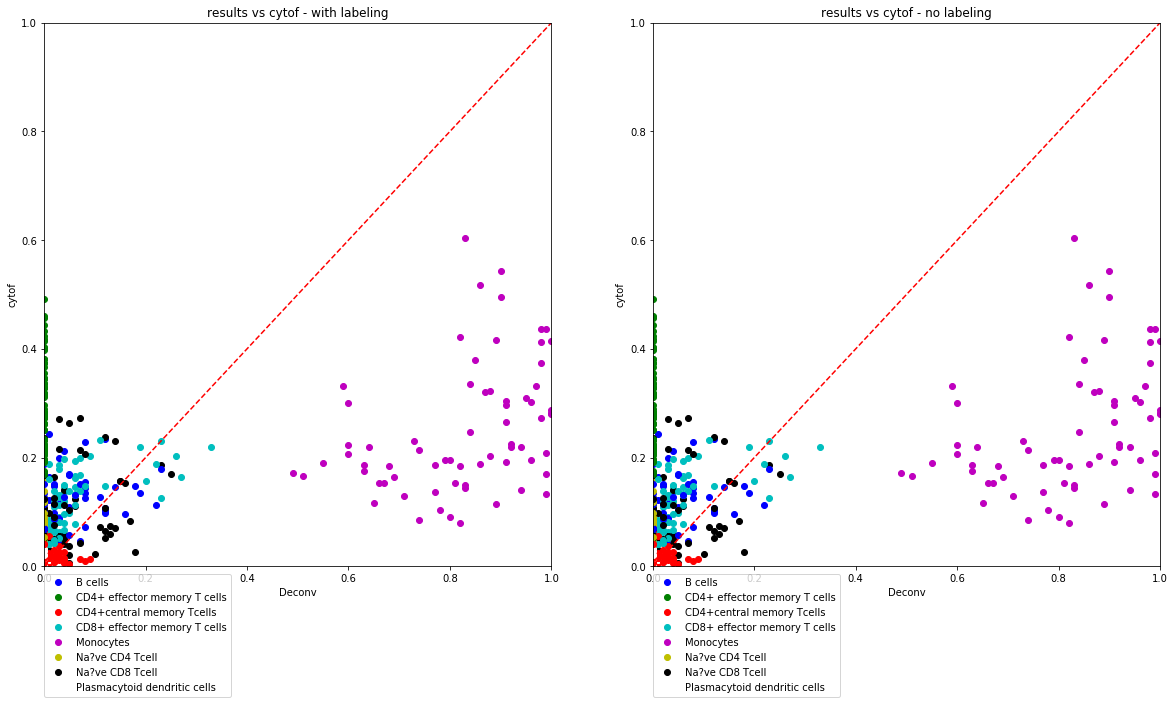

In [16]:
describe_results("4103560338")

In [6]:
# def transform_specific_cytof_pipe(A,B,pip_steps):
#     A = A.copy(deep=True)

#     pip = pipeline.Pipeline(pip_steps)
#     A.deconv.keep_original_data([A, B])
    
#     result = pip.predict([A, B])
#     before_prediction = pip.transform([A,B])
    
#     result , X = _pipe._get_results_and_known_cytof(result, pip, False)
    
#     return [result,before_prediction,X]

In [7]:
# bd = BasicDeconv()
# agg_spec_cells = PpAggToSpecificCells()
# cpm = CellProportionsMeasure(how = "correlation",return_dict_measure_statas = True,with_pvalue = True)


# cells_corr_columns = [c for c in meta_results.columns if "cellcorr" in c]
# relevent_meta = meta_results[cells_corr_columns]

# idx_best_sig_per_cell = relevent_meta.idxmax()

# best_uuids = {}
# for cell, idx in idx_best_sig_per_cell.items():
#     best_uuids[cell] = meta_results.iloc[idx]["uuid"]

# all_sigs = [] 
# all_mixs = []
# for cell,uuid in best_uuids.items() :
#     pipe_steps = _pipe.load_results_from_archive(uuid)["signature"]
#     _,before_prediction,X = transform_specific_cytof_pipe(A_all_vs, B_all_vs,pipe_steps)
#     name = f"corr{cell.split('corr')[1].strip('Mean')}"
#     _sig = before_prediction[0].copy(deep=True)
#     _mix = before_prediction[1].copy(deep=True)
    
#     if "NOT_" in _sig.columns[1] : 
#         _sig = agg_spec_cells.transform([_sig.rename(columns = {col:f"{col}_01" for col in _sig.columns}),None])[0]
#         _sig = _sig.rename(columns={col:col.split("_01")[0] for col in _sig.columns})
        
#     _sig["cell_ind"] = name
#     _sig = _sig.set_index("cell_ind",append=True)
    
#     _mix["cell_ind"] = name
#     _mix = _mix.set_index("cell_ind",append=True)
    
#     all_sigs.append(_sig) 
#     all_mixs.append(_mix)
    
    
# multi_signature = pd.concat(all_sigs)
# multi_mix = pd.concat(all_mixs)


# #now we found the results of bouth cell "types"
# result = bd.fit([multi_signature,multi_mix])

# measure_results = cpm.transform([result,X])
# pip_summary = measure_results

# pip_guid = uuid.uuid1().fields[0]
# pip_summary["uuid"] = pip_guid

# _X_path = os.path.join(r"C:\Repos\deconv_py\deconv_py\experiments\archive",f"known-{pip_guid}.pkl")
# _result_path = os.path.join(r"C:\Repos\deconv_py\deconv_py\experiments\archive",f"result-{pip_guid}.pkl")

# result.to_pickle(_result_path)
# X.to_pickle(_X_path)

# return pd.DataFrame(result_summary)

In [8]:
# df3 = multi_signature.droplevel(2).loc[~multi_signature.droplevel(2).index.duplicated(keep='first')]
# df4 = multi_mix.droplevel(2).loc[~multi_mix.droplevel(2).index.duplicated(keep='first')]

# #now we found the results of bouth cell "types"
# result = bd.fit([df3,df4])
# result

In [9]:
cpm = CellProportionsMeasure(how="correlation", return_dict_measure_statas=True, with_pvalue=True)
multi_result = _pipe.run_multi_signature_pipeline(A_all_vs,B_all_vs,meta_results,cpm)
multi_result

{'corrMean': 0.356, 'corrPval': 0.0, 'uuid': 2882211920}

In [10]:
raise

RuntimeError: No active exception to reraise

In [ ]:
# measure_results = cpm.transform([result,X])
# pip_summary = measure_results

# pip_guid = uuid.uuid1().fields[0]
# pip_summary["uuid"] = pip_guid

# _X_path = os.path.join(r"C:\Repos\deconv_py\deconv_py\experiments\archive",f"known-{pip_guid}.pkl")
# _result_path = os.path.join(r"C:\Repos\deconv_py\deconv_py\experiments\archive",f"result-{pip_guid}.pkl")

# result.to_pickle(_result_path)
# X.to_pickle(_X_path)

# return pd.DataFrame(result_summary)

In [ ]:
# meta_results.sort_values(by="corrMean",ascending=False)[["entropy","corrMean","corrPval","uuid"]].head(10)


## result

In [ ]:
_res = meta_results.sort_values(by="corrMean",ascending=False)[["corrMean","corrPval","entropy","uuid"]]
_res[(_res["corrMean"] > 0.35)&(_res["entropy"] > 1)&(_res["corrPval"] < 0.05)].sort_values(by="entropy")

# best results

## get best results

In [15]:
def build_distance_matrix() :
    uuid_to_results = {}
    for uuid in meta_results["uuid"] : 
        params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
        
        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        res_values = best_results.sort_index(axis=0).sort_index(axis=1).values
        
        uuid_to_results[uuid] = res_values
    
    results = {}
    looked_uuids = {}
    for uuid,res in uuid_to_results.items():
        if uuid in looked_uuids.keys():
            continue
            
        neighbors = [] 
        for sec_uuid,sec_res in uuid_to_results.items():
            if (res == sec_res).all() :
                neighbors.append(sec_uuid)
                looked_uuids[sec_uuid] = sec_uuid
        if len(neighbors) > 1 :
            results[uuid] = neighbors
    
    clusters = [] 
    for _,cluster in  results.items():
        uuids = [] 
        for uuid in cluster : 
            params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
            uuids.append(params)
        clusters.append(pd.concat(uuids,axis=1))
        
    
    return clusters
     
def plot_correlation_per_cell(uuids) : 
    if type(uuids) is str : 
        uuids = [uuids]
    
    max_corr_per_cell = {}
    best_param_per_cell = {}
    
    for uuid in meta_results["uuid"] : 
        params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
        
        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        best_known=best_results_and_known["known"]
        mapping = GlobalUtils.get_corospanding_mixtures_map(best_known,best_results)
        best_known = best_known.rename(columns=mapping)
        best_known = best_known[[col for col in mapping.values()]]

        mutual_col = best_known.columns.intersection(best_results.columns)
        best_results = best_results[mutual_col]
        best_known = best_known[mutual_col]

        corr_per_cell =  best_results.T.corrwith(best_known.T,method="spearman")
        
        for cell in corr_per_cell.index : 
            if cell in max_corr_per_cell.keys() : 
                if corr_per_cell[cell] > max_corr_per_cell[cell] :
                    max_corr_per_cell[cell] = corr_per_cell[cell]
                    best_param_per_cell[cell] = params
            else : 
                max_corr_per_cell[cell] = corr_per_cell[cell]
                best_param_per_cell[cell] = params
    
    return max_corr_per_cell,best_param_per_cell

def plot_results_vs_known_pca(best_results,best_known):
    pca = PCA(n_components=2)
    pca.fit(pd.concat([best_results,best_known],axis=1).T)

    deconv_principalcomp = pca.transform(best_results.T)
    known_principalcomp = pca.transform(best_known.T)

    deconv_principalDf =pd.DataFrame(data = deconv_principalcomp
                 , columns = ['principal component 1', 'principal component 2'],index = best_results.columns)
    known_principalDf = pd.DataFrame(data = known_principalcomp
                 , columns = ['principal component 1', 'principal component 2'],index = best_known.columns)

    deconv_principalDf["color"] = "b"
    known_principalDf["color"] = "r"

    principalDf = deconv_principalDf.append(known_principalDf)
    fig = plt.figure(figsize = (25,15))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('blue - deconvolution result,red -  known proportions', fontsize = 20)

    ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],c=principalDf['color'], s = 50)

    for mixture in range(deconv_principalcomp.shape[0]):
        deconv_point = deconv_principalcomp[mixture,:]
        known_point = known_principalcomp[mixture,:]
        plt.plot([deconv_point[0],known_point[0]],[deconv_point[1],known_point[1]], ':')

    for i, txt in enumerate(principalDf.index):
        ax.annotate(txt, (principalDf['principal component 1'].iloc[i], principalDf['principal component 2'].iloc[i]))

def describe_results(uuids,with_per_mixture_plot = False,with_mixtures_pca = False) : 
    if type(uuids) is str : 
        uuids = [uuids]
    
    for uuid in uuids : 
        params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
        print("params : ")
        display(HTML(params.to_html()))


        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        best_known=best_results_and_known["known"]
        mapping = GlobalUtils.get_corospanding_mixtures_map(best_known,best_results)
        best_known = best_known.rename(columns=mapping)
        best_known = best_known[[col for col in mapping.values()]]

        mutual_col = best_known.columns.intersection(best_results.columns)
        best_results = best_results[mutual_col]
        best_known = best_known[mutual_col]

        print("mixtures : ")
        display(HTML(best_results.to_html()))

        print("mixtures details :")
        display(HTML(best_results.corrwith(best_known,method="spearman").describe().to_frame().to_html()))

        cytof_plots.plot_mass_to_cytof_scatter_all_on_one(best_results,best_known,best_results)
        if with_per_mixture_plot : 
            cytof_plots.plot_mass_to_cytof_scatter(best_results,best_known,best_results)
        if with_mixtures_pca : 
            plot_results_vs_known_pca(best_results,best_known)

In [ ]:
max_corr_per_cell,best_param_per_cell = plot_correlation_per_cell("1501281428")

In [ ]:
best_param_per_cell

# test